## ROME - one model


<br />

for each unique pair of contiguous convective regions (objects), a, b, in a scene:
<br />

$ROME_{pair} = A_{a} + \text{min}(1, \: \frac{A_{b}}{A_{d}}) \cdot A_b$
<br />
\
Where: \
$A_{a}$ - area of larger object of pair \
$A_{b}$ - area of smaller object of pair \
$A_{d}$ - shortest distance between the two objects, squared

<br />

$ROME = \Biggl\{ 
\begin{matrix}
\frac{1}{k} \cdot \sum_{i=1}^{k} ROME_{pair(i)} & n>1\\
A_{a} & n=1
\end{matrix}$
<br />

Where: \
$k$ - number of unique pairs in a scene

<br />


Essentially the pairs are the added areas, unless the distance between the objects is larger than the effective square side of the smaller object. \
In that case the contribution from the smaller area to the pair value is modulated (which would be most of the time for our scenes)

In [1]:
import xarray as xr
import numpy as np
import skimage.measure as skm
import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeat

from os.path import expanduser
home = expanduser("~")

from cmip5_metrics.funcs.vars.myFuncs import *
from cmip5_metrics.funcs.vars.myPlots import *
from cmip5_metrics.funcs.prFuncs import *
from cmip5_metrics.funcs.aggFuncs import *
#import constructed_fields

import timeit

switch = {
    'local_files': True, 
    'nci_files': False, 
    'constructed_fields': False
}

### precipitation

In [6]:
models = [
    # 'IPSL-CM5A-MR', # 1
    'GFDL-CM3',     
    # 'GISS-E2-H',    # 3
    # 'bcc-csm1-1',   # 4
    # 'CNRM-CM5',     # 5
    # 'CCSM4',        # 6 # cannot concatanate files for rcp85 run
    # 'HadGEM2-AO',   # 7
    # 'BNU-ESM',      # 8
    # 'EC-EARTH',     # 9
    # 'FGOALS-g2',    # 10
    # 'MPI-ESM-MR',   # 11
    # 'CMCC-CM',      # 12
    # 'inmcm4',       # 13
    # 'NorESM1-M',    # 14
    # 'CanESM2',      # 15
    # 'MIROC5',       # 16
    # 'HadGEM2-CC',   # 17
    # 'MRI-CGCM3',    # 18
    # 'CESM1-BGC'     # 19
    ]
model = models[0]


experiments = [
    'historical',
    # 'rcp85'
    ]
experiment = experiments[0]       


if switch['local_files']:
    folder = home + '/Documents/data/cmip5/' + model
    fileName = model + '_precip_' + experiment + '.nc'
    path = folder + '/' + fileName
    ds = xr.open_dataset(path)
    precip = ds.precip*60*60*24
    precip.attrs['units']= 'mm/day'

if switch['nci_files']:
    precip = get_pr(model, experiment).precip # from prVars

# if switch['constructed_fields']:
#     precip = constructed_fields.precip_fields

In [7]:
precip

<xarray.DataArray 'tas' (time: 360, lat: 22, lon: 128)>
[1013760 values with dtype=float32]
Coordinates:
  * time     (time) object 1970-01-16 12:00:00 ... 1999-12-16 12:00:00
    height   float64 ...
  * lat      (lat) float64 -29.3 -26.51 -23.72 -20.93 ... 20.93 23.72 26.51 29.3
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Attributes:
    units:    mm/day

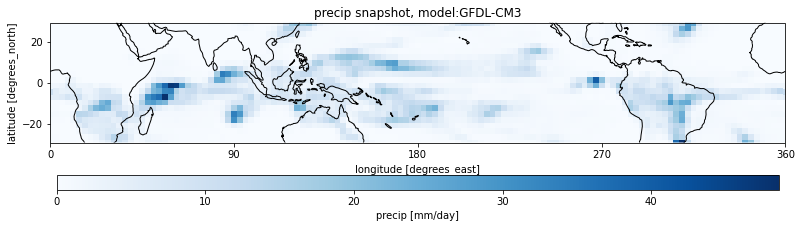

In [4]:
plot_snapshot(precip.isel(time=0), 'Blues', 'precip', model) # from vars.myPlots

### convective threshold and area fraction

In [5]:
pr_percentiles = calc_pr_percentiles(precip) # from prFuncs
pr_percentiles

<xarray.Dataset>
Dimensions:  (time: 10950)
Coordinates:
  * time     (time) object 1970-01-01 12:00:00 ... 1999-12-31 12:00:00
Data variables:
    pr95     (time) float64 14.08 13.81 14.17 14.02 ... 16.82 16.76 16.91 15.32
    pr97     (time) float64 17.44 17.1 17.44 17.31 ... 20.42 21.26 21.76 19.81
    pr99     (time) float64 25.16 28.12 26.33 25.34 ... 25.66 29.67 33.37 31.73
    pr999    (time) float64 46.43 56.0 75.17 68.38 ... 41.02 47.47 67.33 72.96

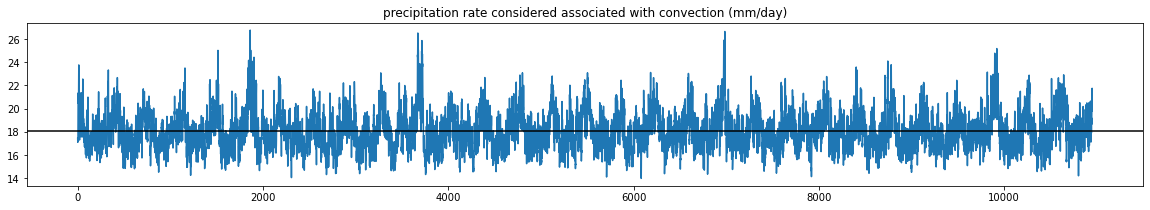

In [6]:
percentile = 'pr97'
conv_threshold = pr_percentiles[percentile].mean(dim=('time'))
plt.figure(figsize= (20,3))
plt.plot(pr_percentiles[percentile])
plt.title('precipitation rate considered associated with convection (mm/day)')
plt.axhline(y=conv_threshold, color='k')

In [7]:
start = timeit.default_timer()
numberIndex = calc_numberIndex(precip, conv_threshold) # from aggFuncs
stop = timeit.default_timer()
print('it takes {} seconds to calculate the number index for model: {}'.format((stop-start), model))

it takes 24.588963624999998 seconds to calculate the number index for model: GFDL-CM3


In [8]:
numberIndex

<xarray.Dataset>
Dimensions:   (time: 10950)
Coordinates:
  * time      (time) object 1970-01-01 12:00:00 ... 1999-12-31 12:00:00
Data variables:
    o_number  (time) float64 16.0 13.0 14.0 12.0 14.0 ... 17.0 16.0 21.0 16.0
    areaf     (time) float64 0.0282 0.02754 0.02669 ... 0.04735 0.04395 0.03731

Text(0.5, 1.0, 'areafraction covered by convection, defined from average percentile precipiitaiton rate (fixed precipitation rate)')

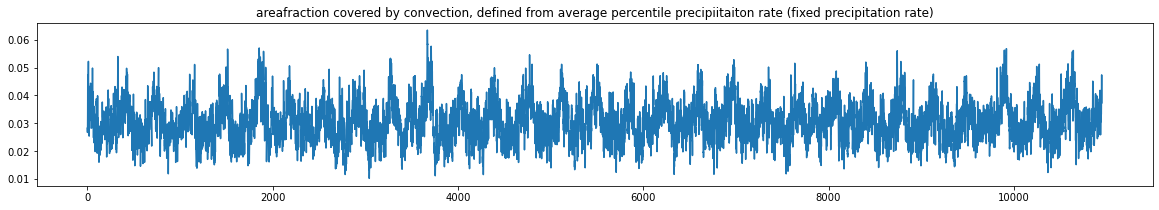

In [9]:
plt.figure(figsize= (20,3))
plt.plot(numberIndex.areaf)
plt.title('areafraction covered by convection, defined from average percentile precipiitaiton rate (fixed precipitation rate)')

### ROME

In [10]:
start = timeit.default_timer()
rome = calc_rome(precip, conv_threshold) # from AggFuncs
stop = timeit.default_timer()
print('it takes {} minutes to calculate rome for model: {}'.format((stop-start)/60, model))

it takes 213.55495975 seconds to calculate rome for model: GFDL-CM3


In [11]:
rome

<xarray.DataArray (time: 10950)>
array([ 683534.43422544,  880457.95304704,  817436.9782266 , ...,
       1267915.78737143,  827632.54100597,  978485.72801879])
Coordinates:
  * time     (time) object 1970-01-01 12:00:00 ... 1999-12-31 12:00:00
Attributes:
    units:    km^2

Text(0.5, 0, 'day')

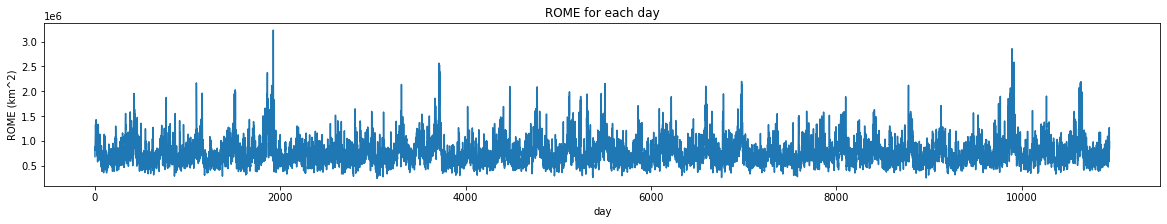

In [17]:
plt.figure(figsize = (20,3))
plt.plot(rome)
plt.title('ROME for each day')
plt.ylabel('ROME (km^2)')
plt.xlabel('day')

In [18]:
start = timeit.default_timer()
n=8
rome_n = calc_rome_n(n, precip, conv_threshold) # from AggFuncs
stop = timeit.default_timer()
print('it takes {} minutes to calculate rome based of {} largest objects for model: {}'.format((stop-start)/60, n, model))

it takes 1.9670228701499999 minutes to calculate rome based of 8 largest objects for model: GFDL-CM3


Text(0.5, 0, 'day')

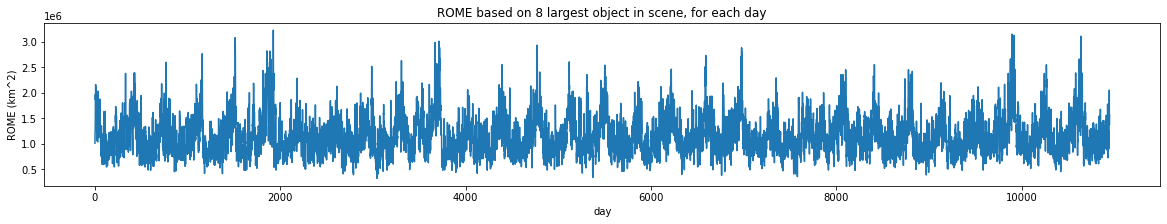

In [20]:
plt.figure(figsize = (20,3))
plt.plot(rome_n)
plt.title('ROME based on {} largest object in scene, for each day'.format(n))
plt.ylabel('ROME (km^2)')
plt.xlabel('day')

In [21]:
saveit = False
if saveit:
    fileName = model + '_pwad_' + experiment + '.nc'
    dataset = xr.Dataset(
        data_vars = {'rome':rome, 
                     'rome_n':rome_n},
        attrs = {'description': 'ROME based on all and the {} largest contiguous convective regions in the scene for each day'.format(n),
                 'units':'km^2'}                  
        )

    if switch['local_files']:
        folder = home + '/Documents/data/cmip5/' + model

    if switch['nci_files']:
        folder = '/g/data/k10/cb4968/data/cmip5/'+ model
        
    if switch['constructed_fields']:
        fileName = 'constructedFields' + '_pwad_' + experiment + '.nc'
        folder = home + '/Documents/data/cmip5/' + model

    save_file(dataset, folder, fileName) # from vars.myFuncs